In [1]:
from sklearn.utils import class_weight

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import cv2


print("📦 Step 1: Loading images...")

# Define image dimensions
img_size = 224

# Dataset path (update if needed)
dataset_path = r"D:\DP\DesignProject\models\fruits_quality_classification\dataset"

# Initialize
images = []
labels = []
classes = os.listdir(dataset_path)
classes.sort()

for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(class_index)

print(f"✅ Loaded {len(images)} images from {len(classes)} classes.")

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print("🔀 Step 2: Splitting dataset...")
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"✅ Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

print("⚙️ Step 3: Preprocessing and augmentation...")

# Scale pixel values
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0

# Define augmentation layer
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

print("📊 Step 4: Calculating class weights...")
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("✅ Class weights calculated.")

print("🧠 Step 5: Building model with MobileNetV2 (transfer learning)...")

base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze to avoid memory spike. Set to True for fine-tuning.

model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("✅ Model compiled.")

print("🚀 Step 6: Starting training...")

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=16,  # Reduced to avoid OOM
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

print("✅ Model training complete.")

print("💾 Step 7: Saving model to 'leaf_model_mobilenetv2.h5'...")
model.save("leaf_model_mobilenetv2.h5")
print("✅ Model saved successfully.")


📦 Step 1: Loading images...
✅ Loaded 2485 images from 3 classes.
🔀 Step 2: Splitting dataset...
✅ Training samples: 1988, Validation samples: 497
⚙️ Step 3: Preprocessing and augmentation...
📊 Step 4: Calculating class weights...
✅ Class weights calculated.
🧠 Step 5: Building model with MobileNetV2 (transfer learning)...
✅ Model compiled.
🚀 Step 6: Starting training...
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.5129 - loss: 1.1891 - val_accuracy: 0.9135 - val_loss: 0.3041 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.8556 - loss: 0.4260 - val_accuracy: 0.9457 - val_loss: 0.1927 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.9160 - loss: 0.2689 - val_accuracy: 0.9497 - val_loss: 0.1455 - learning_rate: 1.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - accuracy: 0.9313 - loss: 0.2060 - val_accuracy: 0.9598 - val_loss: 0.1224 - learning_rate: 1.0

✅ Model training complete.
💾 Step 7: Saving model to 'leaf_model_mobilenetv2.h5'...
✅ Model saved successfully.


In [9]:
! pip install seaborn matplotlib

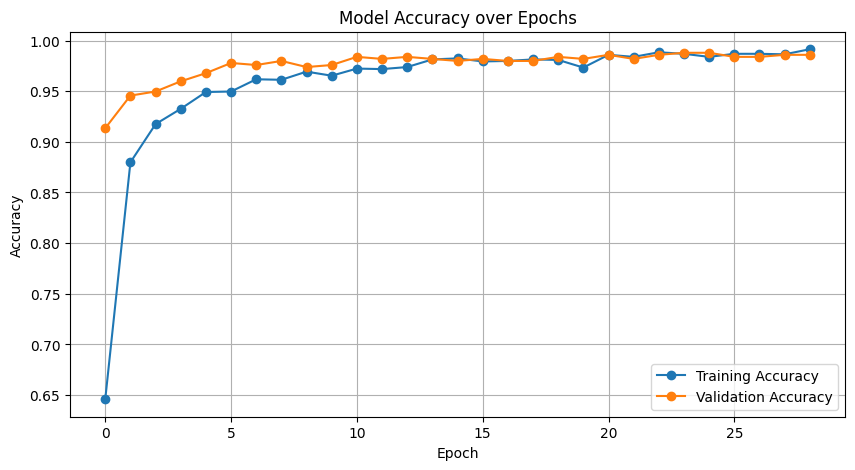

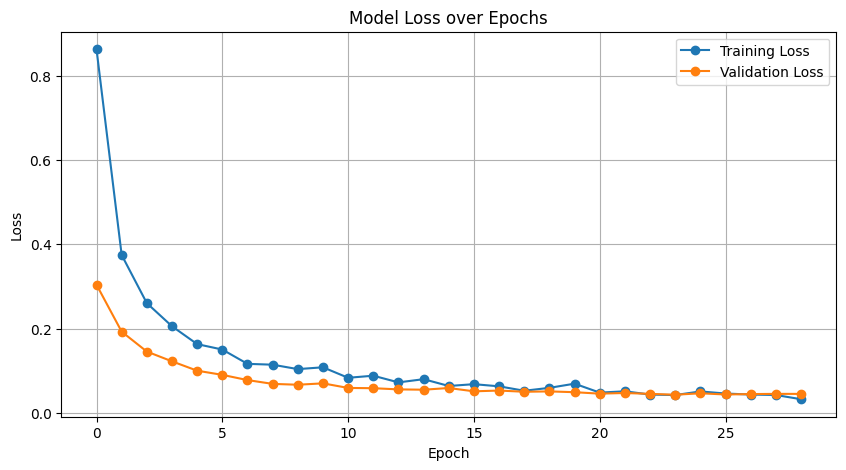

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step


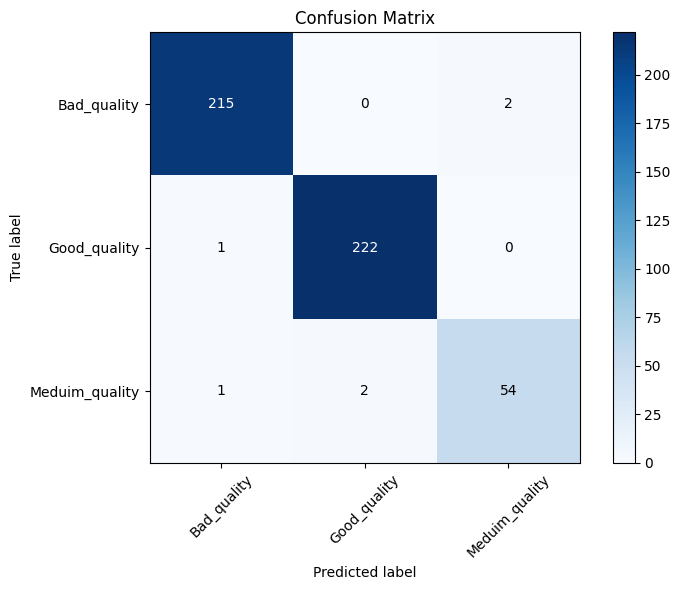

📋 Classification Report:

                precision    recall  f1-score   support

   Bad_quality       0.99      0.99      0.99       217
  Good_quality       0.99      1.00      0.99       223
Meduim_quality       0.96      0.95      0.96        57

      accuracy                           0.99       497
     macro avg       0.98      0.98      0.98       497
  weighted avg       0.99      0.99      0.99       497



In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 📈 Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 📉 Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 🔍 Predict on Validation Set
y_pred_probs = model.predict(X_val_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# 📊 Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Label each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 🧾 Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=classes))


In [3]:
import numpy as np
import tensorflow as tf
import cv2
import os

# 🔧 Configuration
model_path = r"D:\DP\DesignProject\models\fruits_quality_classification\leaf_model_mobilenetv2.h5" # or MobileNet model if you're using that
img_size = 224  # Should match your training image size

# 📂 Class names (ensure they match training order)
dataset_path = r"D:\DP\DesignProject\models\fruits_quality_classification\dataset"
class_names = sorted(os.listdir(dataset_path))  # Sorted for consistent indexing

# 📦 Load model
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded.")

# 🔍 Prediction function
def predict_image(image_path):
    # Step 1: Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Failed to read image at {image_path}")
    
    # Step 2: Resize and scale
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Shape: (1, 224, 224, 3)

    # Step 3: Predict
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    
    # Step 4: Confidence
    confidence = np.max(predictions) * 100

    return predicted_class_name, confidence


✅ Model loaded.


In [4]:
predict_image(r"D:\DP\DP\fruits_quality_classification\dataset\Good_quality\IMG20200729190242.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


('Good_quality', np.float32(98.4323))

In [6]:
import tensorflow as tf
z_model = tf.keras.models.load_model(r"D:\DP\DesignProject\models\fruits_quality_classification\leaf_model_mobilenetv2.h5")
z_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,341 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)